In [39]:
# === VARIABLES ===

# Capture variables
fps = 200  # Frames per second (capture rate)

# Kalman filter gains
alpha = 0.95  # Alpha gain for position estimation
betha = 0.95  # Beta gain for velocity estimation
gamma = 0.05  # Gamma gain for acceleration estimation

# Variation limits to recognize the same fiber between frames
variacion_x = 10  # Allowed variation in the X position (pixels)
variacion_y = 10  # Allowed variation in the Y position (pixels)
variacion_angulo = 5  # Allowed variation in the angle (degrees)

# Number of images to process
numero_imagenes = 600

In [40]:
import cv2
import numpy as np
import os
import json

In [41]:
import math

# === TIME STEP ===
delta_t = 1 / fps  # Time interval between frames based on frames per second

# --------------------------------------------------------------------------------
# 1) HELPER FUNCTIONS TO HANDLE ANGLES
# --------------------------------------------------------------------------------

def normalizar_diferencia_angular(angulo_medido, angulo_filtrado):
    """
    Returns the smallest angular difference within [-180, 180].
    This ensures smooth transitions by correcting jumps like 179 -> -179 or vice versa.
    """
    diff = angulo_medido - angulo_filtrado
    while diff > 180:
        diff -= 360
    while diff <= -180:
        diff += 360
    return diff

def normalizar_angulo(angulo):
    """
    Ensures that the angle is within the range [-180, 180].
    """
    while angulo > 180:
        angulo -= 360
    while angulo <= -180:
        angulo += 360
    return angulo

# --------------------------------------------------------------------------------
# 2) GENERIC ALPHA, BETA, GAMMA FUNCTIONS (FOR LINEAR POSITION)
# --------------------------------------------------------------------------------

def filtro_alpha(x, x_i, z, t):
    """
    Alpha filter adjusts the position estimate.
    x  = current filter value
    x_i = previous filtered value
    z  = measurement (current detection)
    t  = time step
    """
    x_f = x + alpha * (z - x_i)
    return x_f

def filtro_betha(x, x_i, z, t):
    """
    Beta filter adjusts the velocity estimate.
    """
    x_f = x + betha * ((z - x_i) / t)
    return x_f

def filtro_gamma(x, x_i, z, t):
    """
    Gamma filter adjusts the acceleration estimate.
    """
    x_f = x + gamma * ((z - x_i) / (t**2) * 2)
    return x_f

# --------------------------------------------------------------------------------
# 3) SPECIFIC ALPHA, BETA, GAMMA FUNCTIONS FOR ANGLES
# --------------------------------------------------------------------------------

def filtro_alpha_angulo(angulo_filtrado, angulo_medido):
    """
    Applies the alpha filter to the angle, normalizing differences to avoid large jumps.
    """
    diff_ang = normalizar_diferencia_angular(angulo_medido, angulo_filtrado)
    angulo_f = angulo_filtrado + alpha * diff_ang
    angulo_f = normalizar_angulo(angulo_f)  # Ensure angle remains within [-180, 180]
    return angulo_f

def filtro_betha_angulo(omega_filtrado, angulo_filtrado, angulo_medido, t):
    """
    Adjusts angular velocity (omega) based on angular differences.
    """
    diff_ang = normalizar_diferencia_angular(angulo_medido, angulo_filtrado)
    omega_f = omega_filtrado + betha * (diff_ang / t)
    return omega_f

def filtro_gamma_angulo(aceleracion_angular_filtrada, angulo_filtrado, angulo_medido, t):
    """
    Adjusts angular acceleration based on angular differences.
    """
    diff_ang = normalizar_diferencia_angular(angulo_medido, angulo_filtrado)
    a_ang_f = aceleracion_angular_filtrada + gamma * (diff_ang / (t**2) * 0.5)
    return a_ang_f

# --------------------------------------------------------------------------------
# 4) ALPHA-BETA-GAMMA FILTER FOR POSITION (XY) AND ANGLE
# --------------------------------------------------------------------------------

def filtro_kalman(parametros_kalman, deteccion_actual, salto_temporal=1):
    """
    Applies the Kalman-like (alpha-beta-gamma) filter to estimate position, velocity,
    acceleration, angle, and angular motion.

    Args:
        parametros_kalman: List containing the current state of the system:
            [
                [xx,   xy],             # Position
                [vx,   vy],             # Velocity
                [ax,   ay],             # Acceleration
                [angulo],               # Angle
                [omega],                # Angular velocity
                [aceleracion_angular],  # Angular acceleration
                [largo]                 # Length (optional, unchanged by filter)
            ]
        deteccion_actual: List containing the measured state:
            [
                [zxx, zxy],  # Measured position
                [z_angulo],  # Measured angle
                [z_largo]    # Measured length (optional)
            ]
        salto_temporal: Number of frames to skip (default is 1).

    Returns:
        Updated Kalman parameters after correction and prediction.
    """
    t = delta_t * salto_temporal

    # --- Extract current state ---
    xx_i, xy_i = parametros_kalman[0]
    vx_i, vy_i = parametros_kalman[1]
    ax_i, ay_i = parametros_kalman[2]
    angulo_i = parametros_kalman[3][0]
    omega_i = parametros_kalman[4][0]
    aceleracion_angular_i = parametros_kalman[5][0]
    largo = parametros_kalman[6][0]

    # --- Extract current measurements ---
    zxx, zxy = deteccion_actual[0]
    z_angulo = deteccion_actual[1][0]
    z_largo = deteccion_actual[2][0]

    # --- Correction phase (alpha, beta, gamma) ---
    xx_f = filtro_alpha(xx_i, xx_i, zxx, t)
    xy_f = filtro_alpha(xy_i, xy_i, zxy, t)
    vx_f = filtro_betha(vx_i, xx_i, zxx, t)
    vy_f = filtro_betha(vy_i, xy_i, zxy, t)
    ax_f = filtro_gamma(ax_i, xx_i, zxx, t)
    ay_f = filtro_gamma(ay_i, xy_i, zxy, t)
    angulo_f = filtro_alpha_angulo(angulo_i, z_angulo)
    omega_f = filtro_betha_angulo(omega_i, angulo_i, z_angulo, t)
    aceleracion_angular_f = filtro_gamma_angulo(aceleracion_angular_i, angulo_i, z_angulo, t)

    # --- Prediction phase ---
    xx_ff = xx_f + vx_f * t + 0.5 * ax_f * (t**2)
    xy_ff = xy_f + vy_f * t + 0.5 * ay_f * (t**2)
    vx_ff = vx_f + ax_f * t
    vy_ff = vy_f + ay_f * t
    angulo_ff = normalizar_angulo(angulo_f + omega_f * t + 0.5 * aceleracion_angular_f * (t**2))
    omega_ff = omega_f + aceleracion_angular_f * t

    # Update Kalman parameters
    parametros_kalman = [
        [xx_ff, xy_ff],
        [vx_ff, vy_ff],
        [ax_f, ay_f],
        [angulo_ff],
        [omega_ff],
        [aceleracion_angular_f],
        [z_largo]  # Length remains constant or updated if necessary
    ]

    return parametros_kalman

# --------------------------------------------------------------------------------
# 5) INITIAL GUESS
# --------------------------------------------------------------------------------

def conjetura_inicial(parametros_kalman):
    """
    Resets the Kalman parameters to an initial guess, typically used when
    initializing or resetting a tracked object.
    """
    xx_f, xy_f = parametros_kalman[0]
    vx_f = vy_f = ax_f = ay_f = 0
    angulo_f = parametros_kalman[1][0]
    omega_f = aceleracion_angular_f = 0
    largo = parametros_kalman[2][0]

    xx_ff = xx_f + vx_f * delta_t + 0.5 * ax_f * (delta_t**2)
    xy_ff = xy_f + vy_f * delta_t + 0.5 * ay_f * (delta_t**2)
    angulo_ff = normalizar_angulo(angulo_f + omega_f * delta_t + 0.5 * aceleracion_angular_f * (delta_t**2))

    parametros_kalman = [
        [xx_ff, xy_ff],
        [vx_f, vy_f],
        [ax_f, ay_f],
        [angulo_ff],
        [omega_f],
        [aceleracion_angular_f],
        [largo]
    ]
    return parametros_kalman

In [42]:
# === HELPER FUNCTIONS ===

def obtener_carpeta_predict_mas_grande(ruta_base):
    """
    Finds the 'predict' folder with the highest number in the given base path.
    If no such folder exists, returns 'predict'.
    If folders like 'predict', 'predict1', 'predict2', ... exist,
    it returns the next folder name as 'predictN+1'.

    Args:
        ruta_base (str): Base path where the 'predict' folders are located.

    Returns:
        str: The path for the next 'predict' folder (e.g., 'predictN+1').
    """
    # List all folders in the base path that start with 'predict'
    carpetas = [f for f in os.listdir(ruta_base) 
                if f.startswith('predict') and os.path.isdir(os.path.join(ruta_base, f))]
    
    numeros = []
    for carpeta in carpetas:
        try:
            # Extract the number after 'predict', or use 0 for 'predict'
            num = int(carpeta.replace('predict', '')) if carpeta != 'predict' else 0
            numeros.append((num, carpeta))
        except ValueError:
            # Skip folders that don't follow the 'predictN' pattern
            continue

    # Sort by number in descending order
    numeros.sort(reverse=True)

    if numeros:
        # Return the path for the next 'predictN+1' folder
        return os.path.join(ruta_base, f"predict{numeros[0][0] + 1}")
    else:
        # If no 'predict' folders exist, return 'predict'
        return os.path.join(ruta_base, 'predict')


def convertir_a_json_compatible(obj):
    """
    Converts non-serializable data types into JSON-compatible Python native types.

    Args:
        obj: The object to convert.

    Returns:
        JSON-compatible type (e.g., float, int, list).

    Raises:
        TypeError: If the object type is not supported for conversion.
    """
    if isinstance(obj, (np.float32, np.float64)):
        # Convert NumPy float to Python float
        return float(obj)
    if isinstance(obj, (np.int32, np.int64)):
        # Convert NumPy integer to Python int
        return int(obj)
    if isinstance(obj, np.ndarray):
        # Convert NumPy array to Python list
        return obj.tolist()
    # Raise an error if the type is not supported
    raise TypeError(f"Unsupported data type for JSON serialization: {type(obj)}")


In [43]:
#Hough transform functions
def detect_lines_and_properties(
    path_imagen,
    roi_points,
    canny_threshold1=50,
    canny_threshold2=150,
    hough_threshold=20,
    min_line_length=50,
    max_line_gap=5
):
    """
    Detecta líneas en la imagen dada (usando Canny + HoughLinesP) y retorna:
        - centroids: Lista de centroides [(cx, cy), ...].
        - angles: Lista de ángulos (en grados) de cada línea.
        - lengths: Lista de longitudes de cada línea.
        - scores: Lista de "confianzas" (None, pues HoughLinesP no la provee).
        - boxes: Lista de "cajas" [x1, y1, x2, y2] para cada línea detectada.
    """

    # 1) Cargar la imagen
    imagen = cv2.imread(path_imagen)
    if imagen is None:
        print(f"No se pudo cargar la imagen: {path_imagen}")
        return None, None, None, None, None, None  # agregamos la imagen original (None)

    # 2) Convertir a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # 3) Definir la región de interés (ROI) si se especificó
    if roi_points is not None:
        mask = np.zeros_like(gris)
        cv2.fillPoly(mask, [roi_points], 255)
        gris_roi = cv2.bitwise_and(gris, mask)
    else:
        gris_roi = gris

    # 4) Detectar bordes con Canny
    bordes = cv2.Canny(gris_roi, canny_threshold1, canny_threshold2, apertureSize=3)

    # 5) Detectar líneas con HoughLinesP
    lineas = cv2.HoughLinesP(
        bordes,
        1,
        np.pi / 180,
        threshold=hough_threshold,
        minLineLength=min_line_length,
        maxLineGap=max_line_gap
    )

    if lineas is None or len(lineas) == 0:
        print("No se detectaron líneas.")
        # Retornamos la imagen cargada para dibujar la ROI, aunque no haya líneas
        return [], [], [], [], [], imagen

    # 6) Preparar listas de salida
    centroids = []
    angles = []
    lengths = []
    scores = []  # HoughLinesP no provee confianza
    boxes = []

    # 7) Calcular propiedades de cada línea
    for linea in lineas:
        x1, y1, x2, y2 = linea[0]

        # Centroide
        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0

        # Longitud
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)

        # Ángulo ([-180, 180] en atan2; ajusta según convención)
        angle = np.degrees(np.arctan2(dy, dx))

        centroids.append((cx, cy))
        angles.append(angle)
        lengths.append(length)
        scores.append(None)  # no hay score en HoughLinesP
        boxes.append([x1, y1, x2, y2])

    return centroids, angles, lengths, scores, boxes, imagen

def draw_detections(imagen, roi_points, boxes, output_path):
    """
    Dibuja las líneas detectadas (boxes) sobre 'imagen' en color rojo
    y el contorno de la ROI (si se especifica) en verde.
    Guarda la imagen si 'output_path' no es None.
    Retorna la imagen con los dibujos.
    """

    imagen = cv2.imread(imagen)

    # Dibujamos la ROI en verde si existe
    if roi_points is not None:
        cv2.polylines(imagen, [roi_points], isClosed=True, color=(0, 255, 0), thickness=2)

    # Dibujamos cada línea en rojo
    for (x1, y1, x2, y2) in boxes:
        cv2.line(imagen, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Si se especificó 'output_path', guardamos la imagen
    if output_path is not None:
        cv2.imwrite(output_path, imagen)
        cv2.imshow("Imagen", imagen)
        print(f"Imagen guardada en: {output_path}")

    return imagen
    

In [51]:
def ptv (fibras):

    pts = np.array([
        [30, 0],
        [640, 0],
        [640, 840],
        [1024, 840],
        [1024, 980],
        [20, 970]
    ], dtype=np.int32)
    
    carpeta_fotos = f"{fibras} Fibras\\Cam 1"  # Folder containing the photos or frames
    
    # === GET CURRENT DIRECTORY PATH ===
    base = os.getcwd()
    
    # === CONFIGURE PATHS AND PARAMETERS ===
    # Path to the folder containing the images
    # carpeta_imagenes = os.path.join(base, 'runs', 'Fotos')
    carpeta_imagenes = os.path.join(os.path.dirname(base), 'Dataset', carpeta_fotos)
    # Base path where 'predictN' folders are created
    ruta_base = os.path.join(base, 'runs', 'segment')

    print(ruta_base)
    
    # === MAIN LOGIC ===
    
    # Load the YOLO model and initialize paths and image list
    ruta_procesada = obtener_carpeta_predict_mas_grande(ruta_base)

    imagenes = [os.path.join(carpeta_imagenes, img) for img in os.listdir(carpeta_imagenes) 
                if img.lower().endswith(('.jpg', '.png', '.bmp'))]
    imagenes = sorted(imagenes)[:numero_imagenes]
    
    # Dictionary to store information about detected fibers
    dictionary = {}
    current_fiber_id = 0  # Global ID to assign to new fibers
    fibras_imagen_actual = []  # List of fibers detected in the current frame
    fibras_detectadas_imagen = []  # List to track the number of fibers detected per image
    
    # Process each image
    for idx, imagen in enumerate(imagenes):
        print("==========================")
        print(f"\nProcessing image {idx + 1}")
        print(imagen)
        print("==========================")
        # Generate predictions for the current image
        centroids, angles, max_lengths, scores, boxes, imagen_original = detect_lines_and_properties(
            imagen,
            pts,
            canny_threshold1=100,
            canny_threshold2=250,
            hough_threshold=40,
            min_line_length=30,
            max_line_gap=5
        )
    
        # Store the number of fibers detected in the current image
        fibras_detectadas_imagen.append(len(scores))
    
        # Keep track of fibers detected in the previous image
        fibras_imagen_anterior = fibras_imagen_actual
        # Reset the list of fibers for the current image
        fibras_imagen_actual = []
    
        # If no detections are made in the current image, skip processing
        if centroids is None:
            continue
    
        # Temporary dictionary to map detections in the current frame to fiber IDs
        fiber_ids_for_current_frame = {}
    
        # If it's the first image, all detected fibers are new
        if idx == 0:
            for i in range(len(scores)):
                current_fiber_id += 1
                fiber_id_str = str(current_fiber_id)
                # Initialize the entry in the dictionary with detection data
                parametros_kalman = conjetura_inicial([[centroids[i][0], centroids[i][1]], [angles[i]], [max_lengths[i]]])
                dictionary[fiber_id_str] = {
                    "centroide": [[centroids[i][0], centroids[i][1]]],
                    "largo_maximo": [[max_lengths[i]]],
                    "angulo": [[angles[i]]],
                    "frame": [[idx + 1]],
                    "kalman": [parametros_kalman]
                }
                fiber_ids_for_current_frame[i] = fiber_id_str
                fibras_imagen_actual.append(fiber_id_str)
    
        else:
            # Match fibers from the current frame to those in the previous frame
            for i in range(len(scores)):
                found_match = False
    
                for index in fibras_imagen_anterior:
                    if found_match:
                        break  # Stop searching once a match is found
    
                    # Get the last predicted position of the fiber
                    parametros_kalman = dictionary[index]["kalman"][-1]
    
                    # Generate a prediction based on the current detection
                    deteccion_actual = [[centroids[i][0], centroids[i][1]], [angles[i]], [max_lengths[i]]]
                    prediccion = filtro_kalman(parametros_kalman, deteccion_actual, 1)
    
                    delta_x = abs(prediccion[0][0] - centroids[i][0])
                    delta_y = abs(prediccion[0][1] - centroids[i][1])
    
                    # Check if the position is consistent
                    if delta_x < variacion_x and delta_y < variacion_y:
                        delta_largo = abs(prediccion[6][0] - max_lengths[i])
                        delta_angulo = abs(prediccion[3][0] - angles[i])
    
                        # Check if length and angle are also consistent
                        if delta_angulo < variacion_angulo:
                            # Avoid duplicate matches for the same fiber
                            if index in fibras_imagen_actual:
                                continue
    
                            # Update the fiber information in the dictionary
                            dictionary[index]["centroide"].append([centroids[i][0], centroids[i][1]])
                            dictionary[index]["largo_maximo"].append([max_lengths[i]])
                            dictionary[index]["angulo"].append([angles[i]])
                            dictionary[index]["frame"].append([idx + 1])
                            dictionary[index]["kalman"].append(prediccion)
                            fiber_ids_for_current_frame[i] = index
                            found_match = True
                            fibras_imagen_actual.append(index)
                            break
    
                # If no match is found, treat it as a new fiber
                if not found_match:
                    current_fiber_id += 1
                    fiber_id_str = str(current_fiber_id)
                    parametros_kalman = conjetura_inicial([[centroids[i][0], centroids[i][1]], [angles[i]], [max_lengths[i]]])
                    dictionary[fiber_id_str] = {
                        "centroide": [[centroids[i][0], centroids[i][1]]],
                        "largo_maximo": [[max_lengths[i]]],
                        "angulo": [[angles[i]]],
                        "frame": [[idx + 1]],
                        "kalman": [parametros_kalman]
                    }
                    fiber_ids_for_current_frame[i] = fiber_id_str
                    fibras_imagen_actual.append(fiber_id_str)
    
        # Save the processed image with annotations
        if not os.path.exists(ruta_procesada):
            os.makedirs(ruta_procesada)
       
        draw_detections(imagen, pts, boxes, output_path=os.path.join(ruta_procesada, f"imagen_{idx + 1}.jpg"))
    # Add the results folder path to the final dictionary
    dictionary["ruta"] = ruta_procesada
    
    # Add the number of fibers detected per frame to the dictionary
    dictionary["fibras_por_frame"] = fibras_detectadas_imagen
    
    # Save the dictionary with all fiber data to a JSON file
    with open(f"fibras_{fibras}.json", "w") as file:
        json.dump(dictionary, file, indent=4, default=convertir_a_json_compatible)
    
    print("Dictionary saved to fibras.json")


In [52]:
def filtrar (numero_fibras):
    # === OBTAIN CURRENT DIRECTORY PATH ===
    base = os.getcwd()
    
    import json
    
    def filtrar_por_minimo_frames(json_data, min_frames):
        """
        Filters fibers from the JSON data, keeping only those that appear in at least `min_frames` frames.
    
        Args:
            json_data (dict): Original JSON data containing fiber information.
            min_frames (int): Minimum number of frames a fiber must appear in to be retained.
    
        Returns:
            dict: Filtered JSON data containing only fibers that meet the condition.
        """
        # Dictionary to store the filtered fibers
        filtrado = {}
    
        # Preserve general keys like 'ruta' or 'fibras_por_frame' if they exist
        if 'ruta' in json_data:
            filtrado['ruta'] = json_data['ruta']
        if 'fibras_por_frame' in json_data:
            filtrado['fibras_por_frame'] = json_data['fibras_por_frame']
    
        # Iterate through all fiber keys (e.g., "1", "2", etc.)
        for fibra_id, fibra_data in json_data.items():
            # Skip special keys already copied
            if fibra_id in ['ruta', 'fibras_por_frame']:
                continue
            
            # Check if the fiber data contains the 'frame' key
            if 'frame' in fibra_data:
                # The number of frames the fiber appears in is the length of this array
                num_frames = len(fibra_data['frame'])
                
                # If the number of frames is >= min_frames, keep this fiber in the filtered data
                if num_frames >= min_frames:
                    filtrado[fibra_id] = fibra_data
        
        return filtrado
    
    # === MAIN EXECUTION ===
    if __name__ == "__main__":
        # 1. Load the original JSON data
        archivo_fibras = os.path.join(base, f"fibras_{numero_fibras}.json")
        archivo_fibras_filtrado = os.path.join(base, f"fibras_{numero_fibras}_filtrado.json")
        
        with open(archivo_fibras, "r", encoding="utf-8") as f:
            datos_originales = json.load(f)
        
        # 2. Filter the data, keeping only fibers that appear in >= min_frames
        min_frames = 20
        datos_filtrados = filtrar_por_minimo_frames(datos_originales, min_frames)
        
        # 3. Save the filtered data to a new JSON file
        with open(archivo_fibras_filtrado, "w", encoding="utf-8") as f:
            json.dump(datos_filtrados, f, indent=4, ensure_ascii=False)
    
        print(f"Data has been filtered. Only fibers with at least {min_frames} frames are retained.")


In [55]:
concentracion_fibras = ["25", "50", "100", "200", "400", "800"]
#concentracion_fibras = ["25"]
for fibras in concentracion_fibras:
    ptv(fibras)
    filtrar(fibras)

c:\Users\MBX\Desktop\Investigacion\Particle-Tracking-Velocimetry-Improving-Via-Deep-Learning\Particle-Tracking-Velocimetry\Hough-Transform\runs\segment

Processing image 1
c:\Users\MBX\Desktop\Investigacion\Particle-Tracking-Velocimetry-Improving-Via-Deep-Learning\Particle-Tracking-Velocimetry\Dataset\25 Fibras\Cam 1\Basler_acA1440-220uc__40343408__20250123_154326693_0063.bmp
Imagen guardada en: c:\Users\MBX\Desktop\Investigacion\Particle-Tracking-Velocimetry-Improving-Via-Deep-Learning\Particle-Tracking-Velocimetry\Hough-Transform\runs\segment\predict2\imagen_1.jpg

Processing image 2
c:\Users\MBX\Desktop\Investigacion\Particle-Tracking-Velocimetry-Improving-Via-Deep-Learning\Particle-Tracking-Velocimetry\Dataset\25 Fibras\Cam 1\Basler_acA1440-220uc__40343408__20250123_154326693_0064.bmp
Imagen guardada en: c:\Users\MBX\Desktop\Investigacion\Particle-Tracking-Velocimetry-Improving-Via-Deep-Learning\Particle-Tracking-Velocimetry\Hough-Transform\runs\segment\predict2\imagen_2.jpg

Proce

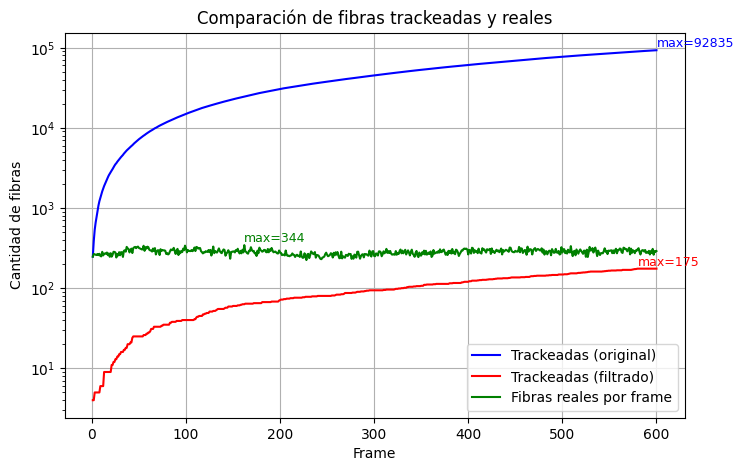

In [56]:
import json
import matplotlib.pyplot as plt

numero_fibras = "800"

base = os.getcwd()

archivo_fibras = os.path.join(base, f"fibras_{numero_fibras}.json")
archivo_fibras_filtrado = os.path.join(base, f"fibras_{numero_fibras}_filtrado.json")

def compute_fibers_tracked_by_frame(datos):
    """
    Dado un diccionario (contenido de un JSON),
    retorna (frames_eje_x, fibras_acumuladas_eje_y), donde:
      - frames_eje_x = [1, 2, ..., max_frame_en_datos]
      - fibras_acumuladas_eje_y[i] = cuántas fibras
        han aparecido en frame <= frames_eje_x[i]
    """
    fibra_min_frame = {}
    max_frame_global = 0

    for key, value in datos.items():
        # Saltamos claves especiales
        if key in ("ruta", "fibras_por_frame"):
            continue

        lista_frames = value.get("frame", [])
        if not lista_frames:
            continue

        # frames como [ [1],[2],...], los convertimos a [1,2,...]
        frames_planos = [f[0] for f in lista_frames]
        min_fr = min(frames_planos)
        fibra_min_frame[key] = min_fr
        max_frame_global = max(max_frame_global, max(frames_planos))

    frames_eje_x = []
    fibras_acumuladas_eje_y = []

    for f in range(1, max_frame_global + 1):
        # Contamos cuántas fibras aparecen por primera vez en un frame <= f
        count = sum(1 for fr in fibra_min_frame.values() if fr <= f)
        frames_eje_x.append(f)
        fibras_acumuladas_eje_y.append(count)

    return frames_eje_x, fibras_acumuladas_eje_y


def plot_comparacion_tres_curvas(datos_original, datos_filtrado):
    """
    Genera una gráfica con:
      1) Fibras trackeadas acumuladas del JSON original.
      2) Fibras trackeadas acumuladas del JSON filtrado.
      3) Cantidad de fibras real por frame (usando 'fibras_por_frame').
    Anotando el valor máximo de cada curva en el gráfico.
    """
    # --- Curva 1: JSON original (fibras trackeadas acumuladas)
    x_orig, y_orig = compute_fibers_tracked_by_frame(datos_original)

    # --- Curva 2: JSON filtrado
    x_filt, y_filt = compute_fibers_tracked_by_frame(datos_filtrado)

    # --- Curva 3: "fibras_por_frame" real (por frame)
    x_real, y_real = [], []
    if "fibras_por_frame" in datos_original:
        lista_real = datos_original["fibras_por_frame"]
        x_real = list(range(1, len(lista_real) + 1))
        y_real = lista_real

    plt.figure(figsize=(8, 5))

    # 1) Trackeadas original
    plt.plot(x_orig, y_orig, color='blue', label='Trackeadas (original)')
    # Anotar el valor máximo si y_orig no está vacío
    if y_orig:
        max_val_orig = max(y_orig)
        idx_orig = y_orig.index(max_val_orig)
        x_pos_orig = x_orig[idx_orig]
        # Agregamos texto cerca del punto máximo
        plt.text(x_pos_orig, max_val_orig,
                 f"max={max_val_orig}",
                 color='blue',
                 ha='left', va='bottom', fontsize=9)

    # 2) Trackeadas filtrado
    plt.plot(x_filt, y_filt, color='red', label='Trackeadas (filtrado)')
    if y_filt:
        max_val_filt = max(y_filt)
        idx_filt = y_filt.index(max_val_filt)
        x_pos_filt = x_filt[idx_filt]
        plt.text(x_pos_filt, max_val_filt,
                 f"max={max_val_filt}",
                 color='red',
                 ha='left', va='bottom', fontsize=9)

    # 3) Fibras reales por frame
    if x_real and y_real:  # Solo si existe la lista
        plt.plot(x_real, y_real, color='green', label='Fibras reales por frame')
        max_val_real = max(y_real)
        idx_real = y_real.index(max_val_real)
        x_pos_real = x_real[idx_real]
        plt.text(x_pos_real, max_val_real,
                 f"max={max_val_real}",
                 color='green',
                 ha='left', va='bottom', fontsize=9)

    plt.yscale('log')

    plt.title('Comparación de fibras trackeadas y reales')
    plt.xlabel('Frame')
    plt.ylabel('Cantidad de fibras')
    plt.grid(True)
    plt.legend()
    plt.show()



if __name__ == "__main__":
    # Carga del JSON original
    with open(archivo_fibras,
              "r", encoding="utf-8") as f:
        datos_orig = json.load(f)

    # Carga del JSON filtrado
    with open(archivo_fibras_filtrado,
              "r", encoding="utf-8") as f:
        datos_filt = json.load(f)

    # Generar la gráfica comparativa (con anotación de los máximos)
    plot_comparacion_tres_curvas(datos_orig, datos_filt)
